In [1]:
from implementations import *
from helpers import *
import numpy as np
import matplotlib.pyplot as plt

## Load the data ###

In [2]:
data_path='./dataset_to_release/'
train_data_path="./dataset_to_release/x_train.csv"
test_data_path="./dataset_to_release/x_test.csv"

In [3]:
x_train, x_test, y_train, train_ids, test_ids=load_csv_data_all(data_path, sub_sample=False)

In [15]:
# change the label -1 by 0
y_train=np.where(y_train==-1, 0, y_train)

## Data Preprocessing

In [4]:
# Handeling the missing values

def replace_nan_by_mean(data):
    ''' function that handels the missing values by replacing them with the column means'''
    nan_indices = np.isnan(data)
    column_means = np.nanmean(data, axis=0)
    data[nan_indices] = np.take(column_means, np.where(nan_indices)[1])
    return data


data_train = replace_nan_by_mean(x_train)


In [5]:
features_to_keep = ["_AGE80", "_AGE65YR", "_AGEG5YR", "_AGE_G", "_AIDTST3", "_ASTHMS1", "_BMI5", "_BMI5CAT",
                     "_CASTHM1", "_CHLDCNT", "_CHOLCHK", "_DRDXAR1", "_DRNKWEK", "_DUALCOR", "_DUALUSE"
                     , "_FLSHOT6", "_FRT16", "_FRTLT1", "_FRTRESP", "_FRUITEX", "_FRUTSUM", "_HCVU651",
                       "_LLCPWT", "_LMTACT1", "_LMTSCL1", "_LMTWRK1", "_LTASTH1", "_MICHD", "_MINAC11", "_MINAC21", 
                       "_MISFRTN", "_MISVEGN", "_MRACE1", "_PA30021", "_PA150R2", "_PA300R2", "_PACAT1", "_PAINDX1", 
                       "_PASTAE1", "_PASTRNG", "_PNEUMO2",
                       "_RFBING5", "_RFBMI5", "_RFCHOL", "_RFDRHV5", "_RFHLTH", "_RFHYPE5", "_RFSMOK3", 
                       "_SMOKER3", "_TOTINDA", "_VEG23", "_VEGESUM", "_VEGETEX", "_VEGLT1", "_VEGRESP"]

In [6]:
# Secode version of data filtering, remove 9 more columns
def filtering(data,data_path):
    columns = extract_first_line(data_path).split(',')
    columns.pop(0)
    filtered_columns = [col for col in columns if col in features_to_keep]
    indices_to_keep = [columns.index(c) for c in filtered_columns]
    print(len(indices_to_keep))

    data_f = data[:, indices_to_keep]
    return(data_f)

In [7]:
data_train_filtered=filtering(data_train, train_data_path)

54


In [9]:
data_train_filtered.shape


(328135, 54)

(array([152679.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0., 136042.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

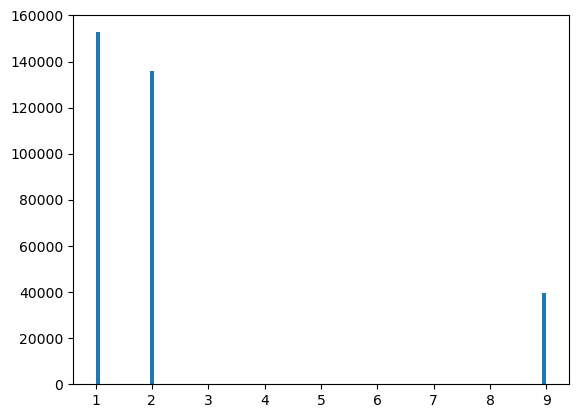

In [76]:
plt.hist(data_train[:,306], bins=100, range=None)

In [10]:
# standardization of the data
def standardize(data):
    small_value=1*10**(-9)
    mean=np.mean(data, axis=0)
    std=np.std(data, axis=0)+small_value
    return((data - mean) / (std))

In [11]:
data_train_standard=standardize(data_train_filtered)

In [12]:
# feature augmentation
def feature_expansion(data, degree):
    augmented_features=[]
    for i in range(data.shape[1]):
        feature=data[:,i]
        augmented_feature=build_poly(feature, degree)
        augmented_features.append(augmented_feature)

    # Stack the augmented features horizontally
    augmented_data = np.hstack(augmented_features)
    return(augmented_data)

   

In [13]:
def apply_model(test, model):
    pred=(sigmoid(test.dot(model))>=0.2).astype(int)
    return(pred)

# Balance the data

In [14]:
def undersample(X, y, majority_class_label):
    # Identify indices of majority and minority classes
    majority_indices = np.where(y == majority_class_label)[0]
    minority_indices = np.where(y != majority_class_label)[0]

    # Determine the number of samples in the minority class
    num_minority_samples = len(minority_indices)

    # Randomly select a subset of the majority class indices
    undersampled_majority_indices = np.random.choice(majority_indices, num_minority_samples, replace=False)

    # Combine minority class indices with the undersampled majority class indices
    undersampled_indices = np.concatenate([undersampled_majority_indices, minority_indices])

    # Obtain the undersampled dataset
    X_undersampled = X[undersampled_indices]
    y_undersampled = y[undersampled_indices]

    return X_undersampled, y_undersampled

In [20]:
x_undersampled, y_undersampled =undersample(data_train_standard, y_train, 0)

(array([28975.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 28975.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

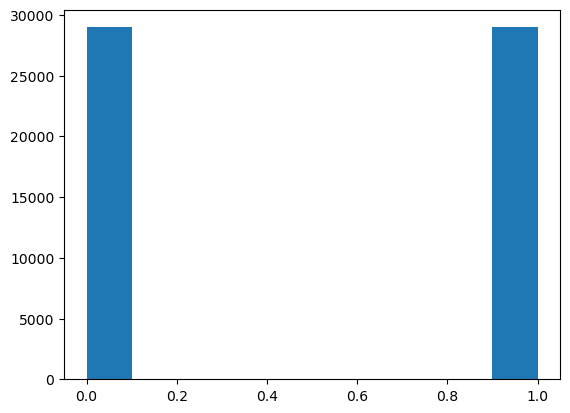

In [19]:
plt.hist(y_undersampled)

In [24]:
x_undersampled.shape

(57950, 54)

## Cross-Validation

In [25]:
def compute_f1_score(true_labels, predicted_labels):
    """
    Computes the F1 score for a classification model using NumPy.

    Parameters:
    true_labels (numpy.ndarray): True labels for the data.
    predicted_labels (numpy.ndarray): Predicted labels from the model.

    Returns:
    f1 (float): The F1 score.
    """
    true_positive = np.sum(np.logical_and(true_labels == 1, predicted_labels == 1))
    false_positive = np.sum(np.logical_and(true_labels == 0, predicted_labels == 1))
    false_negative = np.sum(np.logical_and(true_labels == 1, predicted_labels == 0))
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1

In [26]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    
    return np.array(k_indices)

In [27]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression for a fold corresponding to k_indices

    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()
        degree:     scalar, cf. build_poly()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)

    """

    # ***************************************************
    # get k'th subgroup in test, others in train:
    train_idx=np.reshape(k_indices[[i for i in range(len(k_indices)) if i!=k]], -1)
    test_idx=k_indices[k]

    x_train=x[train_idx,:]
    print(x_train.shape)
    y_train=y[train_idx]
    x_test=x[test_idx,:]
    y_test=y[test_idx]
    
    y_tr=np.expand_dims(y_train, 1)
    y_te=np.expand_dims(y_test, 1)

    y_tr=np.where(y_tr == -1, 0, y_tr)
    print(y_tr, y_tr.shape)
    y_te=np.where(y_te == -1, 0, y_te)

    max_iters = 1000
    gamma=0.5

    # ***************************************************
    # form data with polynomial degree: 
    print('on va auggmenter le data')
    train_data=feature_expansion(x_train, degree)
    test_data=feature_expansion(x_test, degree)
    train_data=standardize(train_data)
    test_data=standardize(test_data)
    # ***************************************************
     # build tx
    tx_tr = np.c_[np.ones((y_train.shape[0], 1)), train_data]
    tx_te = np.c_[np.ones((test_data.shape[0], 1)), test_data]
    print(tx_tr.shape)
    print(tx_te.shape)
    initial_w=np.zeros((tx_tr.shape[1], 1))

    # reg logistic regression: 
    w=reg_logistic_regression(y_tr,tx_tr,lambda_,initial_w, max_iters, gamma)[0]
    print(w.shape)
    print(tx_te.shape)
    y_pred=apply_model(tx_te, w)
    # calculate f1 score on test:
    f1_te=compute_f1_score(y_te, y_pred)
  
    return f1_te

In [28]:
def cross_validation_demo(degree, k_fold, lambdas):
    """cross validation over regularisation parameter lambda.

    Args:
        degree: integer, degree of the polynomial expansion
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_rmse : scalar, the associated root mean squared error for the best lambda
    """

    seed = 12
    #degree = degree
    k_fold = k_fold
    # split data in k fold
    k_indices = build_k_indices(y_train, k_fold, seed)
    # define lists to store the loss of training data and test data
    f1_score=np.zeros((len(degree), len(lambdas)))
    # cross validation over lambdas:
    for i in range(len(degree)):
        d=degree[i]
        for j in range(len(lambdas)):
            lambda_=lambdas[j]
            cross_val=[cross_validation(y_train, data_train_filtered_2, k_indices, k, lambda_, d) for k in range(k_fold)]
            f1=np.mean(cross_val)
            f1_score[i,j]=f1
    print('on y est presque')
    best_degree=degree[np.unravel_index(np.argmax(f1_score, axis=None), f1_score.shape)[0]]
    best_lambda=lambdas[np.unravel_index(np.argmax(f1_score, axis=None), f1_score.shape)[1]]
    best_f1=np.max(f1_score)
    
    return best_degree, best_f1 , best_lambda , f1_score

In [29]:
#best_degree, best_f1 , best_lambda , f1_score= cross_validation_demo(np.array([2]).astype(int), 2, np.array([10e-6]))

In [64]:
f1_score

array([[0.]])

In [31]:
best_degree

5

In [49]:
#augmented_data=feature_expansion(data_train_filtered_2, 5)

## Training

In [30]:
#split the test set in two


def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.

    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.
    """
    N=int(ratio*len(x))
    # set seed
    np.random.seed(seed)
    # split the data based on the given ratio: 
    shuffled_data=np.random.permutation(x)
    #print(shuffled_data)
    np.random.seed(seed)
    shuffled_labels=np.random.permutation(y)
    #print(shuffled_labels)
    x_tr=shuffled_data[:N] #train data
    x_te=shuffled_data[N:] #test data
    y_tr=shuffled_labels[:N]#train labels
    y_te=shuffled_labels[N:]# test labels

    return(x_tr,x_te, y_tr, y_te)

In [68]:
x_tr,x_te, y_tr, y_te=split_data(x_undersampled, y_undersampled, ratio=0.8)


In [69]:
print(y_tr.shape, x_tr.shape)

(46360,) (46360, 54)


In [70]:
y_tr=np.expand_dims(y_tr, 1)

In [71]:
# Binary classification using logistic regression

max_iters = 1000
gamma = 0.5

 # build tx
tx_tr = np.c_[np.ones((y_tr.shape[0], 1)), x_tr]
initial_w=np.zeros((tx_tr.shape[1], 1))


In [72]:
w,loss= logistic_regression(y_tr, tx_tr, initial_w, max_iters, gamma=0.5)

Current iteration=0, loss=0.5998126777798487
Current iteration=100, loss=0.5271918184765653
Current iteration=200, loss=0.5269144890725734
Current iteration=300, loss=0.5267838794511502
Current iteration=400, loss=0.526695866608413
Current iteration=500, loss=0.5266335515885244
Current iteration=600, loss=0.5265876880085215
Current iteration=700, loss=0.5265527237577479
Current iteration=800, loss=0.5265251999862144
Current iteration=900, loss=0.5265028985116879
loss=0.5264845323910472


In [61]:
lambda_ = 10e-4
w_reg,loss_reg= reg_logistic_regression(y_train, tx_tr, lambda_, initial_w, max_iters, gamma)

Current iteration=0, loss=0.6291172121345341
Current iteration=100, loss=0.24737708402551115
Current iteration=200, loss=0.24337991538293094
Current iteration=300, loss=0.24779171148463944
Current iteration=400, loss=0.24213046423714568
Current iteration=500, loss=0.2491880787058022
Current iteration=600, loss=0.24227415696543095
Current iteration=700, loss=0.24801066506027328
Current iteration=800, loss=0.24194129964823735
Current iteration=900, loss=0.24888557069293624
Current iteration=1000, loss=0.24211734755104491
Current iteration=1100, loss=0.24787888264098157
Current iteration=1200, loss=0.24183521074562278
Current iteration=1300, loss=0.24886487760572557
Current iteration=1400, loss=0.2420684023914077
Current iteration=1500, loss=0.24776977394316002
Current iteration=1600, loss=0.2417791215034302
Current iteration=1700, loss=0.24887336007689037
Current iteration=1800, loss=0.24204755752488158
Current iteration=1900, loss=0.2477085792901911
Current iteration=2000, loss=0.241749

In [62]:
w_reg.shape

(391, 1)

## Test and Accuracy

In [73]:
tx_te=np.c_[np.ones((x_te.shape[0], 1)), x_te]

In [74]:
y_te=np.expand_dims(y_te, 1)

In [75]:
w.shape

(55, 1)

In [76]:
y_pred=apply_model(tx_te, w)

In [77]:
y_pred.shape

(11590, 1)

In [78]:
len(y_te)

11590

In [79]:
#Calculate accuracy
correct_predictions = np.sum((y_pred == y_te))
total_samples = len(y_te)
accuracy = correct_predictions / total_samples

In [80]:
(y_pred == y_te).shape

(11590, 1)

In [81]:
compute_f1_score(y_te, y_pred)

0.7440905780308548

In [82]:
print(accuracy)

0.6665228645383952


## Test

In [63]:
xt=replace_nan_by_mean(x_test)

In [64]:
x_test.shape

(109379, 321)

In [65]:
xt_filtered=filtering_2(xt, test_data_path)

65


In [66]:
xt_filtered.shape

(109379, 65)

In [67]:
augmented_data_test=feature_expansion(xt_filtered, 5)

In [68]:
augmented_data_test.shape

(109379, 390)

In [69]:

xt_standardized=standardize(augmented_data_test)
xtest=np.c_[np.ones((xt.shape[0], 1)), xt_standardized]


In [70]:
xtest.shape

(109379, 391)

In [71]:
predictions=apply_model(xtest, w_reg)
predictions=np.where(predictions==0,-1, predictions)

In [72]:
predictions


array([[-1],
       [-1],
       [-1],
       ...,
       [-1],
       [-1],
       [-1]])

In [73]:
create_csv_submission(test_ids, predictions, 'predictions_LR_0.2_5.csv')